# LeNet5 training on MNIST with different learning rate scheduling, using learning rate range test

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time
import matplotlib.pyplot as plt

### Utilizing GPU

In [21]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


### Download the MNIST dataset 

In [22]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


### Compute average pixel intensity over all training set and all channels

In [23]:
mean= train_data.mean()

print(mean)

tensor(0.1307)


### Compute standard deviation

In [24]:
std= train_data.std()

print(std)

tensor(0.3081)


### Make a LeNet5 convnet class. 

In [25]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   28 x 28  -->    50 x 28 x 28 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 7 x 7 = 4900 -->  100 
        self.linear1 = nn.Linear(4900, 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100 
        x = x.view(-1, 4900)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:   4900  -->  10 
        x = self.linear2(x)
    
        return x

### Build the net. How many parameters in total?

In [52]:
net=LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4900, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)
There are 536710 (0.54 million) parameters in this neural network


### Send the weights of the networks to the GPU (as well as the mean and std)

In [55]:
net = net.to(device)

mean=mean.to(device)

std=std.to(device)

## 1st experiment

### Choose the criterion, optimizer, learning rate scheduler (here MultiStepLR), and batch size.

In [47]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8,12,16,20], gamma=0.5)

bs= 120

### Function to evaluate the network on the test set

In [48]:
def eval_on_test_set():

    running_loss=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs].unsqueeze(dim=1)
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std    # ONLY CHANGE IS HERE!

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label)
        
        running_loss += loss.detach().item()
        
        num_batches+=1

    
    total_loss = running_loss/num_batches
    return total_loss

### Do 30 passes through the training set. 

In [49]:
start=time.time()
epochs = []
losses_multistepLR = []
eval_loss = []
for epoch in range(1,30):
    
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std      
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    lr = scheduler.get_last_lr()
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    print(' ')
    
    epochs.append(epoch)
    losses_multistepLR.append(total_loss)
    eval_loss.append(eval_on_test_set())

    scheduler.step()

    

epoch= 1 	 time= 0.043840185801188154 min 	 lr= [0.1] 	 loss= 0.17735251147206874 	 error= 5.4416621208190925 percent
 
epoch= 2 	 time= 0.08882648547490438 min 	 lr= [0.1] 	 loss= 0.055219033564440904 	 error= 1.7499949693679808 percent
 
epoch= 3 	 time= 0.1336917241414388 min 	 lr= [0.1] 	 loss= 0.03994602596899494 	 error= 1.2666622638702392 percent
 
epoch= 4 	 time= 0.17855384349822997 min 	 lr= [0.1] 	 loss= 0.03477512529725209 	 error= 1.0949956536293028 percent
 
epoch= 5 	 time= 0.22345669666926066 min 	 lr= [0.05] 	 loss= 0.017067704804358073 	 error= 0.5233303427696229 percent
 
epoch= 6 	 time= 0.26839734315872193 min 	 lr= [0.05] 	 loss= 0.012701734461763408 	 error= 0.3466643452644348 percent
 
epoch= 7 	 time= 0.31317783196767174 min 	 lr= [0.05] 	 loss= 0.011573210814123741 	 error= 0.34833096265792846 percent
 
epoch= 8 	 time= 0.35787215232849123 min 	 lr= [0.05] 	 loss= 0.012046242602576968 	 error= 0.34333101511001585 percent
 
epoch= 9 	 time= 0.4025606195131938 m

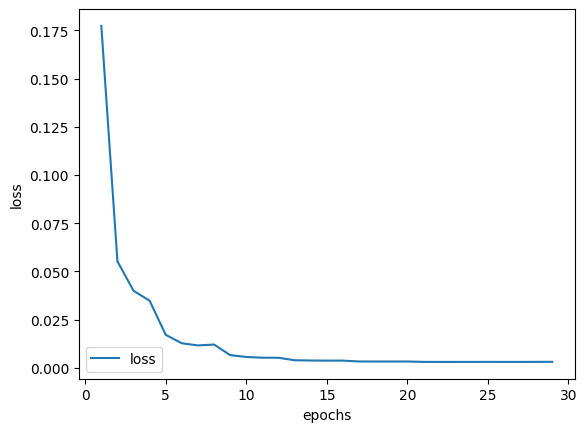

In [50]:
plt.plot(epochs, losses_multistepLR, label = "loss")
plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

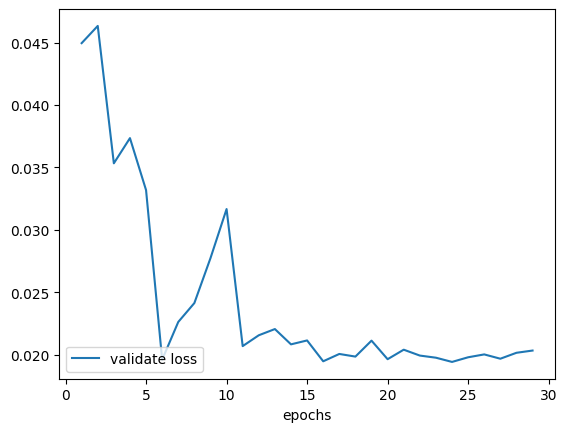

In [39]:
plt.plot(epochs, eval_loss, label = "validate loss")
plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.show()

### Choose image at random from the test set and see how good/bad are the predictions

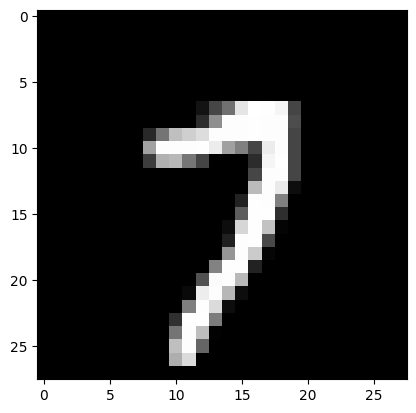

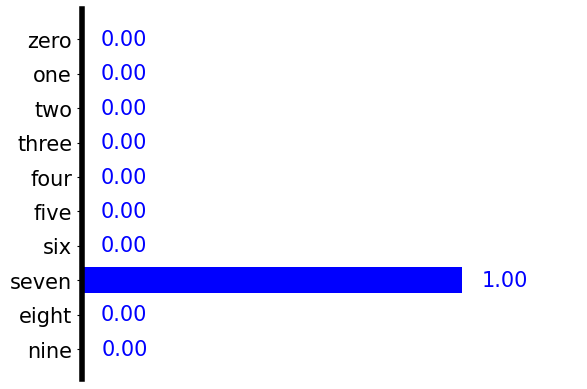

In [40]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im= (im-mean) / std
im=im.view(1,28,28).unsqueeze(dim=1)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_mnist(probs.cpu())

## 2nd experiment : OneCycle

### Choose the criterion, optimizer, learning rate scheduler (here OneCycle), and batch size.

In [56]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch= int(60000/120), final_div_factor = 5, epochs=30)

bs= 120

In [57]:
start=time.time()
epochs = []
losses_onecycle = []
eval_loss_onecycle = []
for epoch in range(1,30):
    
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std      
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1 
        
        scheduler.step()
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    lr = scheduler.get_last_lr()
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    print(' ')
    
    epochs.append(epoch)
    losses_onecycle.append(total_loss)
    eval_loss_onecycle.append(eval_on_test_set())

    

    

epoch= 1 	 time= 0.04407234191894531 min 	 lr= [0.006896028088316533] 	 loss= 0.3271749859638512 	 error= 9.811662304401397 percent
 
epoch= 2 	 time= 0.08939779202143351 min 	 lr= [0.01523465490791949] 	 loss= 0.06767655223235489 	 error= 2.1249953985214236 percent
 
epoch= 3 	 time= 0.13471177816390992 min 	 lr= [0.028009676396827235] 	 loss= 0.04986810939759016 	 error= 1.5433284282684325 percent
 
epoch= 4 	 time= 0.17995792627334595 min 	 lr= [0.043679558344176306] 	 loss= 0.03932979298569262 	 error= 1.2083286881446837 percent
 
epoch= 5 	 time= 0.22508293787638348 min 	 lr= [0.060353449989128026] 	 loss= 0.03378909275692422 	 error= 1.0983285188674927 percent
 
epoch= 6 	 time= 0.27019114096959435 min 	 lr= [0.07601934889229382] 	 loss= 0.0283514939697925 	 error= 0.8966626167297364 percent
 
epoch= 7 	 time= 0.31536777019500734 min 	 lr= [0.08878688491816143] 	 loss= 0.025855788589338773 	 error= 0.8249957799911498 percent
 
epoch= 8 	 time= 0.36034695704778036 min 	 lr= [0.097

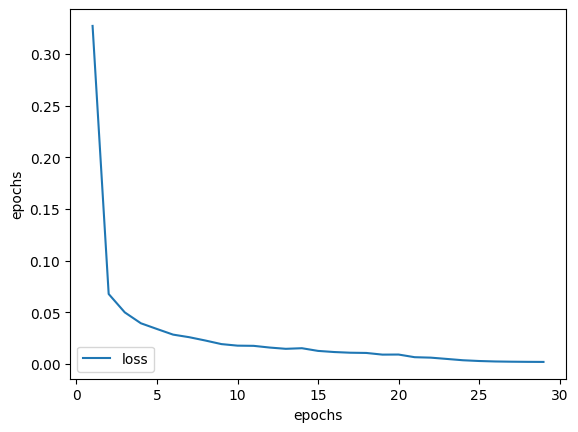

In [58]:
plt.plot(epochs, losses_onecycle, label = "loss")
plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.ylabel("epochs")
plt.show()

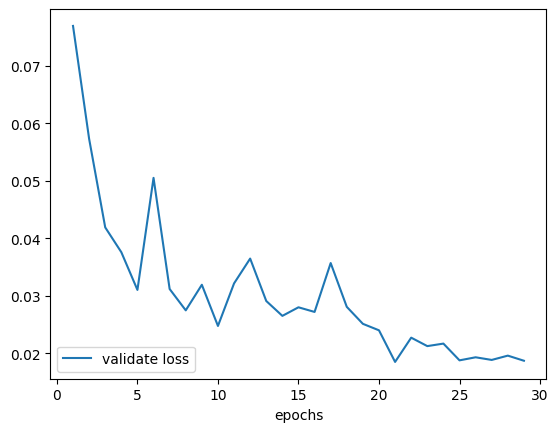

In [59]:
plt.plot(epochs, eval_loss_onecycle, label = "validate loss")
plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.show()

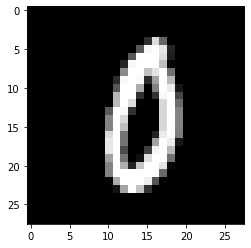

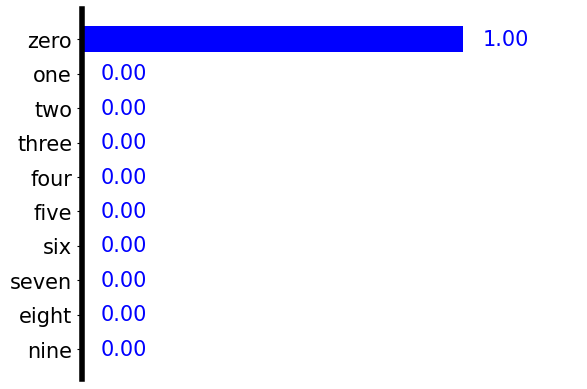

In [34]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im= (im-mean) / std
im=im.view(1,28,28).unsqueeze(dim=1)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_mnist(probs.cpu())